# Knn Regression

1. Choose K (the number of clusters you want).

2. Initialize K centroids randomly.

3. Repeat until convergence:
   a. Assign each data point to the nearest centroid.
   b. Recalculate the centroids based on the current assignment of data points.
   
4. Return the final K centroids and the corresponding cluster assignments.


### Import Modules and Read Dataset

In [106]:
# import modules 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline 

In [107]:
df = pd.read_csv('../../cleaning-preprocessing/cleaned_flight_data_with_target.csv')
df.head(5)

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_ELAPSED_TIME,DISTANCE,CRS_DEP_M,CRS_ARR_M,Temperature,Dew Point,Humidity,...,Condition_Light Snow / Windy,Condition_Mostly Cloudy,Condition_Mostly Cloudy / Windy,Condition_Partly Cloudy,Condition_Partly Cloudy / Windy,Condition_Rain,Condition_Rain / Windy,Condition_Snow,Condition_Wintry Mix,Condition_Wintry Mix / Windy
0,11,1,5,124,636,324,448,48,34,58,...,False,False,False,False,False,False,False,False,False,False
1,11,1,5,371,2475,340,531,48,34,58,...,False,False,False,False,False,False,False,False,False,False
2,11,1,5,181,1069,301,482,48,34,58,...,False,False,False,False,False,False,False,False,False,False
3,11,1,5,168,944,345,513,48,34,58,...,False,False,False,False,False,False,False,False,False,False
4,11,1,5,139,760,360,499,46,32,58,...,False,False,False,False,False,False,False,False,False,False


In [108]:
df = df.astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28820 entries, 0 to 28819
Columns: 111 entries, MONTH to Condition_Wintry Mix / Windy
dtypes: int64(111)
memory usage: 24.4 MB


### Outilers Testing

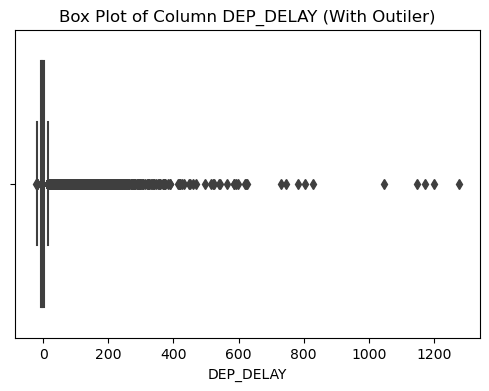

In [109]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df['DEP_DELAY'])
plt.title("Box Plot of Column DEP_DELAY (With Outiler)")
plt.show()

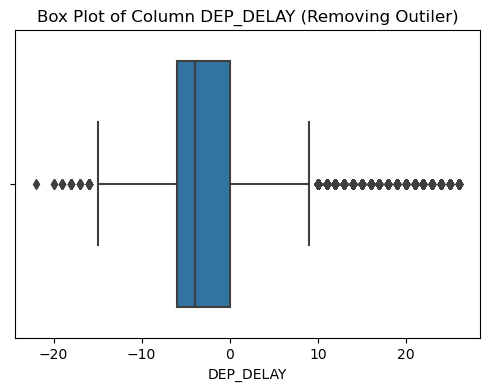

In [110]:
# Compute IQR
Q1 = df['DEP_DELAY'].quantile(0.25)
Q3 = df['DEP_DELAY'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

# Filter out outliers
df = df[(df['DEP_DELAY'] >= lower_bound) & (df['DEP_DELAY'] <= upper_bound)]

# print(df.info())

plt.figure(figsize=(6,4))
sns.boxplot(x=df['DEP_DELAY'])
plt.title("Box Plot of Column DEP_DELAY (Removing Outiler)")
plt.show()

Skewness of DEP_DELAY: 0.8582243204661562


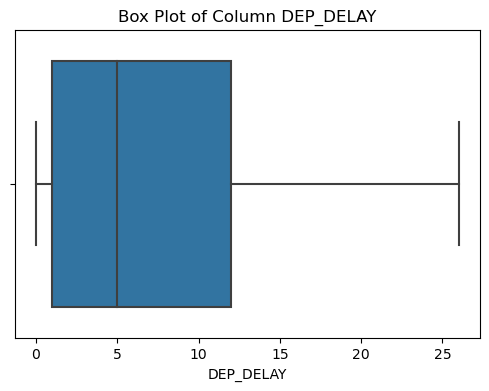

In [111]:
# Spliting the dataset
# Getting DEP_DELAY for the once only delay 
# any positive values means that it is early departure

df = df[df['DEP_DELAY'] >= 0]
# df = df.head(1000) #sampling the first 1000 dataset

df['DEP_DELAY_shifted'] = df['DEP_DELAY'] - df['DEP_DELAY'].min() + 1
# df['DEP_DELAY_log'] = np.log1p(df['DEP_DELAY_shifted'])

print(f"Skewness of DEP_DELAY: {df['DEP_DELAY'].skew()}")  # If > 0.5 or < -0.5, transformation is needed
# print(df['DEP_DELAY_shifted'].skew())  # If > 0.5 or < -0.5, transformation is needed

plt.figure(figsize=(6,4))
sns.boxplot(x=df['DEP_DELAY'])
plt.title("Box Plot of Column DEP_DELAY")
plt.show()
# 

In [112]:
X = df.drop(columns=['DEP_DELAY', ]) #Dropping DEP_DELAY Log/Sqrt transform cols

X = df.drop(columns=['DEP_DELAY']) #Dropping DEP_DELAY Log/Sqrt transform cols

y = df['DEP_DELAY']
# y = df['DEP_DELAY_shifted']

y.head(3)

8     0
9     3
21    0
Name: DEP_DELAY, dtype: int64

### Feature Selection

In [113]:
# X = X.applymap(lambda x: max(x, 0))
# X = X.fillna(X.mean())

In [114]:
k_num_features = 5  # Number of top features to select

In [115]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SelectKBest with f_regression
k = k_num_features 
selector = SelectKBest(score_func=f_regression, k=k)
X_selected = selector.fit_transform(X_scaled, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
feature_scores = selector.scores_[selector.get_support()]

# Create a DataFrame with feature names and scores
feature_df = pd.DataFrame({'Feature': selected_features, 'F-Score': feature_scores})
feature_df = feature_df.sort_values(by='F-Score', ascending=False)

# Print the selected features
print("Selected Features:")
print(feature_df)

Selected Features:
                Feature    F-Score
1             CRS_DEP_M  56.418797
2  OP_UNIQUE_CARRIER_B6  50.762158
0      CRS_ELAPSED_TIME  19.856646
3  OP_UNIQUE_CARRIER_MQ  18.431693
4  OP_UNIQUE_CARRIER_OO  17.943886


### Split Training and Test Data 80:20

In [116]:
from sklearn.model_selection import train_test_split 
# X needs to be updated 

X_train, X_test, y_train, y_test = train_test_split(X[feature_df['Feature']], y, test_size = 0.2, random_state = 42)

In [117]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### KNN Model

In [118]:
from sklearn.neighbors import KNeighborsRegressor
regressor = KNeighborsRegressor(n_neighbors=9, metric='manhattan', weights='distance')
regressor.fit(X_train, y_train)

KNeighborsRegressor(metric='manhattan', n_neighbors=9, weights='distance')

### Results (MSE, MAE,  Predic vs Acutal Graph)

In [119]:
y_pred = regressor.predict(X_test)

In [120]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

print("\nModel Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
# print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Average Prediction {np.mean(y_pred)}")

# print(f"R-Squared (R2): {r2:.4f}")


Model Performance Metrics:
Mean Squared Error (MSE): 70.54
Average Prediction 7.427599128489425


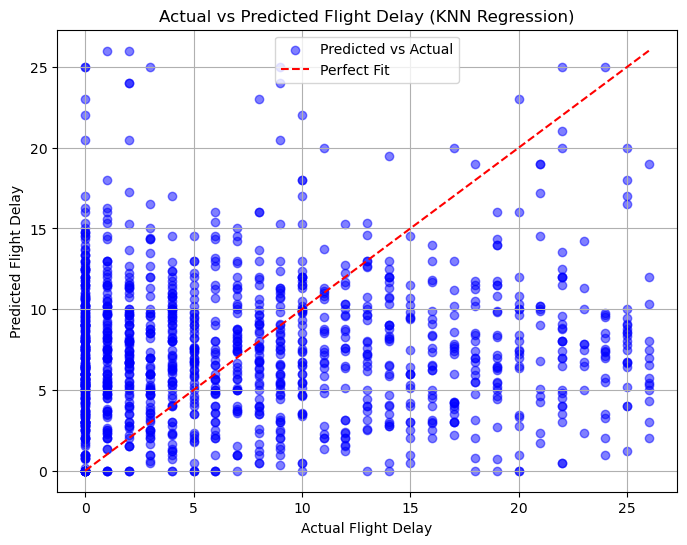

In [121]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label="Predicted vs Actual")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="Perfect Fit")

plt.xlabel("Actual Flight Delay")
plt.ylabel("Predicted Flight Delay")
plt.title("Actual vs Predicted Flight Delay (KNN Regression)")
plt.legend()
plt.grid(True)
plt.show()

### Grid Search 

To find the best k value for knn

In [122]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': range(3, 11, 2)}
grid = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='r2')
grid.fit(X_train, y_train)
print("Best k:", grid.best_params_)

Best k: {'n_neighbors': 9}
